In [38]:
import torch 
import torchvision
import pandas as pd
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
device='cuda' if torch.cuda.is_available() else 'cpu'

In [39]:
df=pd.read_csv("AMZN.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000


In [40]:
df=df[["Date","Close"]]
df['Date']=pd.to_datetime(df['Date'])
df["Close"].values

array([9.79170000e-02, 8.64580000e-02, 8.54170000e-02, ...,
       1.02410004e+02, 1.03949997e+02, 1.01099998e+02])

In [44]:
from copy import deepcopy
def prepare_data(df,n_steps):

    df=deepcopy(df)
    
    df["Date"]=pd.to_datetime(df["Date"])

    df.set_index("Date",inplace=True)

    for i in range(1,n_steps+1):
        df[f"close(t-{i})"]=df["Close"].shift(i)

    df.dropna(inplace=True)
    return df
shifted_df=prepare_data(df,7)


In [45]:

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(-1,1))

shifted_df=shifted_df.sample(frac=1)


In [46]:
data=torch.tensor(shifted_df.values)
data=data.type(torch.float32)
m=data.shape[0]
X_train=data[:round(0.8*m),1:].unsqueeze(dim=2)
y_train=data[:round(0.8*m),0].unsqueeze(dim=1)

X_test=data[round(0.8*m):,1:].unsqueeze(dim=2)
y_test=data[round(0.8*m):,0].unsqueeze(dim=1)


In [47]:
from torch.utils.data import Dataset
class stock(Dataset):
    def __init__(self,X,y):
        self.X=X
        self.y=y
    def __len__(self):
        return (self.X.shape[0])
    def __getitem__(self,i):
        return self.X[i],self.y[i]
train_data=stock(X_train,y_train)
test_data=stock(X_test,y_test)
test_loader=torch.utils.data.DataLoader(dataset=test_data,batch_size=32,shuffle=True)
train_loader=torch.utils.data.DataLoader(dataset=train_data,batch_size=32,shuffle=True)


In [48]:
for x,y in train_loader:
    print(y.shape)
    break

torch.Size([32, 1])


In [49]:
X_test.shape

torch.Size([1302, 7, 1])

In [50]:
class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,num_stacked_layers):
        super().__init__()
        self.hidden=hidden_size

        self.inp=input_size

        self.num=num_stacked_layers

        self.lstm=nn.LSTM(input_size,hidden_size,num_stacked_layers,batch_first=True)

        self.fc=nn.Linear(hidden_size,1)
    def forward(self,x):
        batch_size=x.size(0)
        h0=torch.zeros(1,batch_size,self.hidden).to(device)
        c0=torch.zeros(1,batch_size,self.hidden).to(device)
        out,_=self.lstm(x,(h0,c0))
        out=self.fc(out[:,-1,:])
        return out
model=LSTM(1,4,1).to(device)
loss_fn=torch.nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.01)
model



LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [51]:
from helper_.engine import train
result=train(model,train_loader,test_loader,optimizer,loss_fn,40,device)


  2%|▎         | 1/40 [00:00<00:21,  1.83it/s]

Epoch: 1 | train_loss: 2993.6177 | train_acc: 0.0000 | test_loss: 3506.1295 | test_acc: 0.0000


  5%|▌         | 2/40 [00:01<00:21,  1.78it/s]

Epoch: 2 | train_loss: 2743.0312 | train_acc: 0.0000 | test_loss: 3206.5985 | test_acc: 0.0000


  8%|▊         | 3/40 [00:01<00:20,  1.85it/s]

Epoch: 3 | train_loss: 2520.8228 | train_acc: 0.0000 | test_loss: 2975.2627 | test_acc: 0.0000


 10%|█         | 4/40 [00:02<00:19,  1.89it/s]

Epoch: 4 | train_loss: 2329.0474 | train_acc: 0.0000 | test_loss: 2743.3018 | test_acc: 0.0000


 12%|█▎        | 5/40 [00:02<00:18,  1.92it/s]

Epoch: 5 | train_loss: 2146.7100 | train_acc: 0.0000 | test_loss: 2536.7377 | test_acc: 0.0000


 15%|█▌        | 6/40 [00:03<00:17,  1.95it/s]

Epoch: 6 | train_loss: 1983.5303 | train_acc: 0.0000 | test_loss: 2356.9805 | test_acc: 0.0000


 18%|█▊        | 7/40 [00:03<00:16,  1.97it/s]

Epoch: 7 | train_loss: 1830.6591 | train_acc: 0.0000 | test_loss: 2179.3897 | test_acc: 0.0000


 20%|██        | 8/40 [00:04<00:16,  1.97it/s]

Epoch: 8 | train_loss: 1694.0265 | train_acc: 0.0000 | test_loss: 2022.7436 | test_acc: 0.0000


 22%|██▎       | 9/40 [00:04<00:15,  1.99it/s]

Epoch: 9 | train_loss: 1565.6698 | train_acc: 0.0000 | test_loss: 1868.2529 | test_acc: 0.0000


 25%|██▌       | 10/40 [00:05<00:14,  2.00it/s]

Epoch: 10 | train_loss: 1447.6090 | train_acc: 0.0000 | test_loss: 1737.8239 | test_acc: 0.0000


 28%|██▊       | 11/40 [00:05<00:14,  2.01it/s]

Epoch: 11 | train_loss: 1334.7340 | train_acc: 0.0000 | test_loss: 1619.0603 | test_acc: 0.0000


 30%|███       | 12/40 [00:06<00:14,  1.98it/s]

Epoch: 12 | train_loss: 1233.2121 | train_acc: 0.0000 | test_loss: 1477.3011 | test_acc: 0.0000


 32%|███▎      | 13/40 [00:06<00:13,  1.97it/s]

Epoch: 13 | train_loss: 1135.8397 | train_acc: 0.0000 | test_loss: 1383.2586 | test_acc: 0.0000


 35%|███▌      | 14/40 [00:07<00:13,  1.98it/s]

Epoch: 14 | train_loss: 1047.2492 | train_acc: 0.0000 | test_loss: 1269.5953 | test_acc: 0.0000


 38%|███▊      | 15/40 [00:07<00:12,  1.97it/s]

Epoch: 15 | train_loss: 963.7993 | train_acc: 0.0000 | test_loss: 1168.9512 | test_acc: 0.0000


 40%|████      | 16/40 [00:08<00:12,  1.96it/s]

Epoch: 16 | train_loss: 887.3062 | train_acc: 0.0000 | test_loss: 1082.8667 | test_acc: 0.0000


 42%|████▎     | 17/40 [00:08<00:12,  1.90it/s]

Epoch: 17 | train_loss: 816.6191 | train_acc: 0.0000 | test_loss: 987.1769 | test_acc: 0.0000


 45%|████▌     | 18/40 [00:09<00:11,  1.91it/s]

Epoch: 18 | train_loss: 750.5617 | train_acc: 0.0000 | test_loss: 904.1374 | test_acc: 0.0000


 48%|████▊     | 19/40 [00:09<00:10,  1.94it/s]

Epoch: 19 | train_loss: 691.0233 | train_acc: 0.0000 | test_loss: 843.6279 | test_acc: 0.0000


 50%|█████     | 20/40 [00:10<00:10,  1.96it/s]

Epoch: 20 | train_loss: 632.8850 | train_acc: 0.0000 | test_loss: 767.6522 | test_acc: 0.0000


 52%|█████▎    | 21/40 [00:10<00:09,  1.93it/s]

Epoch: 21 | train_loss: 583.7253 | train_acc: 0.0000 | test_loss: 708.2862 | test_acc: 0.0000


 55%|█████▌    | 22/40 [00:11<00:09,  1.93it/s]

Epoch: 22 | train_loss: 534.7724 | train_acc: 0.0000 | test_loss: 652.5335 | test_acc: 0.0000


 57%|█████▊    | 23/40 [00:11<00:08,  1.96it/s]

Epoch: 23 | train_loss: 490.6547 | train_acc: 0.0000 | test_loss: 604.0314 | test_acc: 0.0000


 60%|██████    | 24/40 [00:12<00:08,  1.97it/s]

Epoch: 24 | train_loss: 452.0955 | train_acc: 0.0000 | test_loss: 550.8190 | test_acc: 0.0000


 62%|██████▎   | 25/40 [00:12<00:07,  1.98it/s]

Epoch: 25 | train_loss: 416.6530 | train_acc: 0.0000 | test_loss: 515.4849 | test_acc: 0.0000


 65%|██████▌   | 26/40 [00:13<00:07,  2.00it/s]

Epoch: 26 | train_loss: 387.2213 | train_acc: 0.0000 | test_loss: 471.6733 | test_acc: 0.0000


 68%|██████▊   | 27/40 [00:13<00:06,  1.96it/s]

Epoch: 27 | train_loss: 355.9860 | train_acc: 0.0000 | test_loss: 430.9121 | test_acc: 0.0000


 70%|███████   | 28/40 [00:14<00:06,  1.95it/s]

Epoch: 28 | train_loss: 328.3458 | train_acc: 0.0000 | test_loss: 398.4182 | test_acc: 0.0000


 72%|███████▎  | 29/40 [00:14<00:05,  1.93it/s]

Epoch: 29 | train_loss: 305.9990 | train_acc: 0.0000 | test_loss: 381.6532 | test_acc: 0.0000


 75%|███████▌  | 30/40 [00:15<00:05,  1.89it/s]

Epoch: 30 | train_loss: 280.4048 | train_acc: 0.0000 | test_loss: 335.5733 | test_acc: 0.0000


 78%|███████▊  | 31/40 [00:16<00:04,  1.82it/s]

Epoch: 31 | train_loss: 256.0929 | train_acc: 0.0000 | test_loss: 313.5364 | test_acc: 0.0000


 80%|████████  | 32/40 [00:16<00:04,  1.83it/s]

Epoch: 32 | train_loss: 235.6253 | train_acc: 0.0000 | test_loss: 280.4236 | test_acc: 0.0000


 82%|████████▎ | 33/40 [00:17<00:03,  1.85it/s]

Epoch: 33 | train_loss: 214.8353 | train_acc: 0.0000 | test_loss: 254.6128 | test_acc: 0.0000


 85%|████████▌ | 34/40 [00:17<00:03,  1.82it/s]

Epoch: 34 | train_loss: 197.8402 | train_acc: 0.0000 | test_loss: 233.9502 | test_acc: 0.0000


 88%|████████▊ | 35/40 [00:18<00:02,  1.71it/s]

Epoch: 35 | train_loss: 177.5698 | train_acc: 0.0000 | test_loss: 220.2862 | test_acc: 0.0000


 90%|█████████ | 36/40 [00:18<00:02,  1.67it/s]

Epoch: 36 | train_loss: 188.9450 | train_acc: 0.0000 | test_loss: 187.6697 | test_acc: 0.0000


 92%|█████████▎| 37/40 [00:19<00:01,  1.67it/s]

Epoch: 37 | train_loss: 143.5559 | train_acc: 0.0000 | test_loss: 147.1583 | test_acc: 0.0000


 95%|█████████▌| 38/40 [00:20<00:01,  1.62it/s]

Epoch: 38 | train_loss: 114.4131 | train_acc: 0.0000 | test_loss: 120.8586 | test_acc: 0.0000


 98%|█████████▊| 39/40 [00:21<00:00,  1.36it/s]

Epoch: 39 | train_loss: 93.5824 | train_acc: 0.0000 | test_loss: 120.3042 | test_acc: 0.0000


100%|██████████| 40/40 [00:22<00:00,  1.80it/s]

Epoch: 40 | train_loss: 83.2996 | train_acc: 0.0000 | test_loss: 87.2665 | test_acc: 0.0000


In [52]:
with torch.inference_mode():
    predicted=model(X_test.to(device)).to('cpu').numpy()


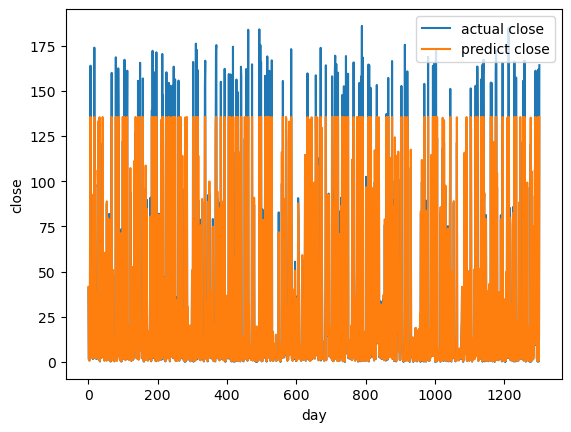

In [53]:
plt.plot(y_test,label='actual close')
plt.plot(predicted,label='predict close')
plt.xlabel('day')
plt.ylabel('close')
plt.legend()
plt.show()